In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [68]:
air = pd.read_csv('rsqa-indice-qualite-air-2022-2024.csv')

#Write datetime column
air['heure'] = air['heure'].astype(str).str.zfill(2)
air['corDate'] = air['date'].astype(str) + ' ' + air['heure'].astype(str)
air['DateTime'] = pd.to_datetime(air['corDate'], format='%Y-%m-%d %H')
air = air.drop(['date','heure','corDate'], axis=1)
air.sort_values(by='DateTime', inplace = True)
air = air.set_index('DateTime')


#Select PM pollutant and station to investigate
PM = air[air['polluant'] == 'PM']
PM3 = PM[PM['stationId'] == 3]

In [75]:
PM4 = PM3.resample('H').bfill()
PM4

,stationId,polluant,valeur
DateTime,,,
2022-01-01 00:00:00,3,PM,57
2022-01-01 01:00:00,3,PM,58
2022-01-01 02:00:00,3,PM,60
2022-01-01 03:00:00,3,PM,62
2022-01-01 04:00:00,3,PM,68
...,...,...,...
2023-02-05 19:00:00,3,PM,25
2023-02-05 20:00:00,3,PM,28
2023-02-05 21:00:00,3,PM,29


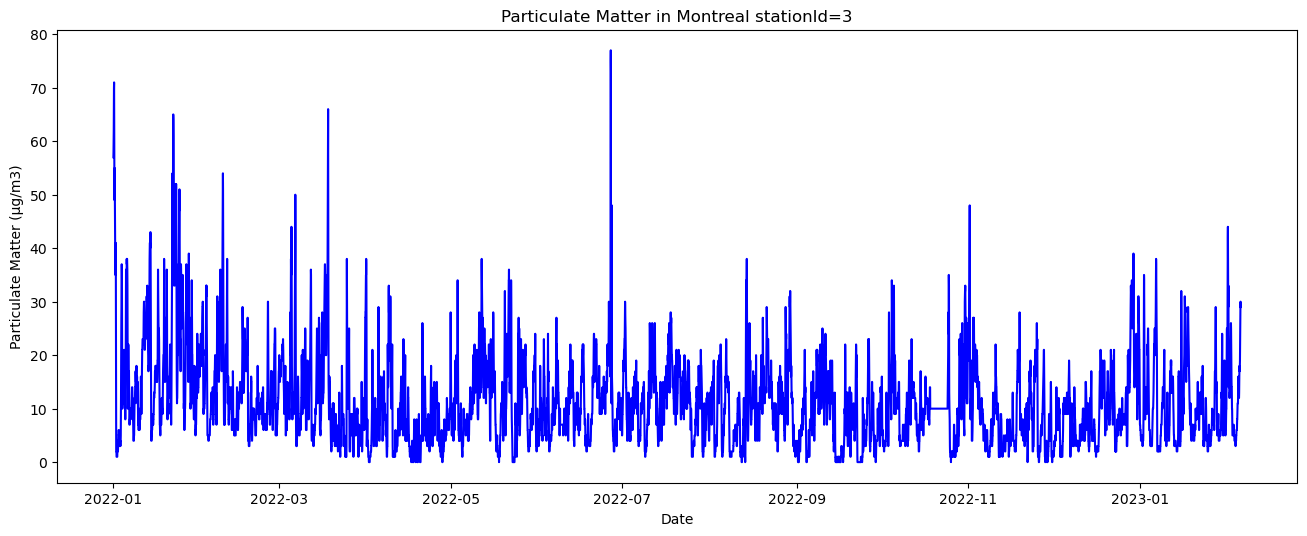

In [76]:
#Plot
def plot_df(df, x, y, title='', xlabel='Date', ylabel='Particulate Matter (µg/m3)', dpi=100, col=''):
    plt.figure(figsize=(16,6), dpi=100)
    plt.plot(x, y, color=col)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(PM4, x = PM4.index, y = PM4.valeur, title = 'Particulate Matter in Montreal stationId=3', col = 'blue')

In [79]:
#Splitting data
train = PM4[PM4.index < pd.to_datetime('2023-01-01', format = '%Y-%m-%d')]
test = PM4[PM4.index > pd.to_datetime('2023-01-01', format = '%Y-%m-%d')]

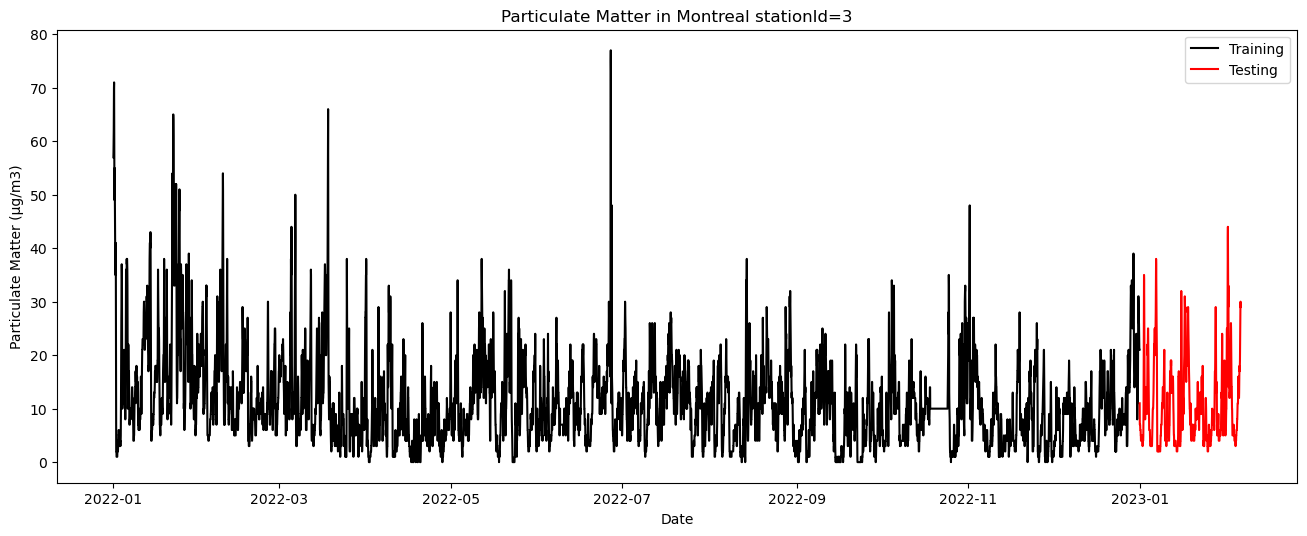

In [80]:
#Plot splitted data
plt.figure(figsize=(16,6), dpi=100)
plt.plot(train.index,train.valeur, color = 'black', label = 'Training')
plt.plot(test.index,test.valeur, color = 'red', label = 'Testing')
plt.gca().set(title='Particulate Matter in Montreal stationId=3', xlabel='Date', ylabel='Particulate Matter (µg/m3)')
plt.legend()
plt.show()

In [81]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [90]:
y = train.valeur
ARMAmodel = SARIMAX(y, order = (2,0,2)).fit()

In [91]:
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


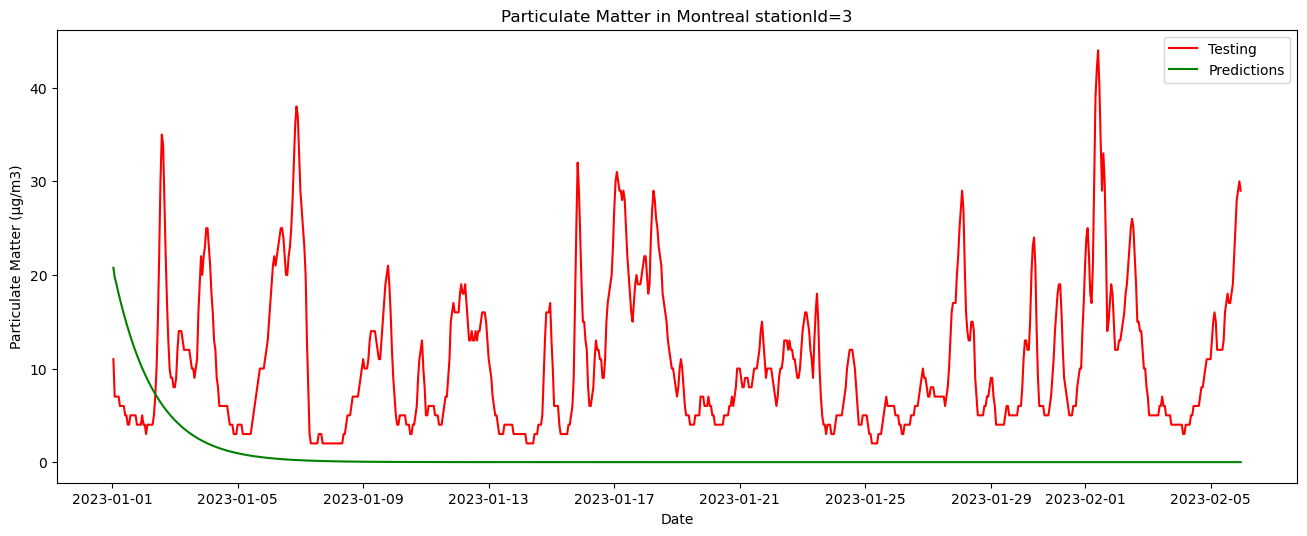

In [92]:
#Plot splitted data
plt.figure(figsize=(16,6), dpi=100)
#plt.plot(train.index,train.valeur, color = 'black', label = 'Training')
plt.plot(test.index,test.valeur, color = 'red', label = 'Testing')
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.gca().set(title='Particulate Matter in Montreal stationId=3', xlabel='Date', ylabel='Particulate Matter (µg/m3)')
plt.legend()
plt.show()